# Acute Lymphoblastic Leukemia (ALL) Detection using Deep Learning

### Import libraries

Importing libraries relevant for the pre-processing and preparation of data

In [1]:
# libraries for basic and preprocessing functions
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import random
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
import random

2023-09-20 15:17:31.258508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Seed value to control randomness

In [2]:
SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

### Loading dataset
Loading raw dataset (from Kaggle) from local machine and assigned to folders

In [3]:
# train set
all_0 = 'C-NMC_Leukemia/training_data_fold/fold_0/all'
all_1 = 'C-NMC_Leukemia/training_data_fold/fold_1/all'
all_2 = 'C-NMC_Leukemia/training_data_fold/fold_2/all'

hem_0 = 'C-NMC_Leukemia/training_data_fold/fold_0/hem'
hem_1 = 'C-NMC_Leukemia/training_data_fold/fold_1/hem'
hem_2 = 'C-NMC_Leukemia/training_data_fold/fold_2/hem'

# test set
test_dir = 'C-NMC_Leukemia/testing_data'

Merge image paths by adding them to a 'train_paths' array.

In [4]:
# array for all images' paths
train_paths = []

# function to get each image's path
def img_path(file_path):
    img_paths = []
    img_files = os.listdir(file_path)
    for img in img_files:
        if img.endswith(".bmp"):
            image = os.path.join(file_path, img)
            img_paths.append(image)
    return img_paths

# store each image's path to train_paths
for f in [all_0, all_1, all_2, hem_0, hem_1, hem_2]:
    every_path = img_path(f)
    train_paths.extend(every_path)

print("Total number of images in training set:", len(train_paths))

Total number of images in training set: 10661


In [5]:
print(train_paths[1])

C-NMC_Leukemia/training_data_fold/fold_0/all/UID_4_4_2_all.bmp


In [6]:
# directory for all training images
train_dir = 'C-NMC_Leukemia/train_merged'
for path in train_paths:
    filename = os.path.basename(path)
    train_path = os.path.join(train_dir, filename)
    shutil.copy(path, train_dir)

Display 5 random images from raw dataset

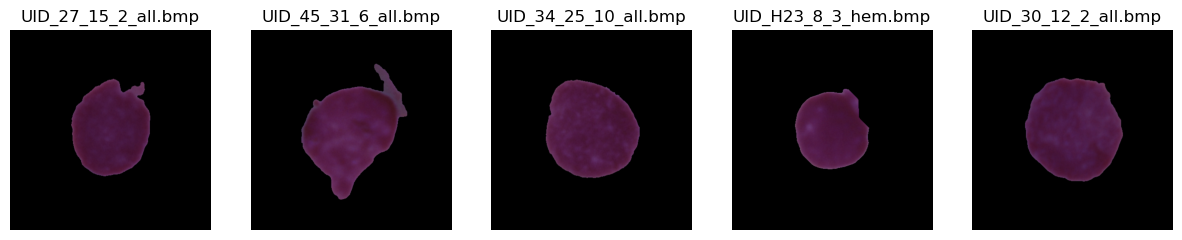

In [7]:
# display 5 random images
disp_img = random.sample(train_paths, 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, img_path in enumerate(disp_img):
    image = cv2.imread(img_path)
    axes[i].imshow(image)
    axes[i].axis("off")
    label = img_path.split("/")[-1]
    axes[i].set_title(label)
plt.show()

Original size of images

In [8]:
from PIL import Image
size = []

for i in train_paths:
    img = Image.open(i)

    # Get the original image size
    img_width, img_height = img.size
    size.append(img.size)

print(list(set(size)))

[(450, 450)]


# Prepocessing images

#### Cropping

In [9]:
def crop_imgs(train_dir):
    cropped_paths = [] # array to store cropped images
    cropped_dir = 'C-NMC_Leukemia/cropped_data'
    for image_name in os.listdir(train_dir):
        image_path = os.path.join(train_dir, image_name)
        image = cv2.imread(image_path)
        
        # convert image colour to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # apply threshold to convert it to binary image
        _, threshold = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        # find contours of the cell in an image
        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # initialise contour border
        cell_border = 0
        # iterate through contours in the frame
        for c in contours:
            if cv2.contourArea(c) > cell_border:
                cell_border = cv2.contourArea(c)
                # get coordinates to bound the cell
                (x, y, w, h) = cv2.boundingRect(c)
        # crop original image to coordinates of the rectangle
        cropped_image = image[y:y+h, x:x+w]
        
        # create path for cropped image 
        cropped_path = os.path.join(cropped_dir, image_name)
        # write cropped image to its path 
        cv2.imwrite(cropped_path, cropped_image)
        # store cropped images to cropped_paths array
        cropped_paths.append(cropped_path)
    return cropped_paths

#### Resize

In [10]:
def resize_imgs(cropped_paths, resized_size):
    resized_paths = [] # array to store resized images
    resized_dir = 'C-NMC_Leukemia/resized_data'
    # iterate through the cropped images
    for crop_path in cropped_paths:
        image = cv2.imread(crop_path)
        
        # resize cropped image to 'resized_size' size
        resized_image = cv2.resize(image, resized_size)
        # create path for resized image
        resized_path = os.path.join(resized_dir, crop_path.split("/")[-1])
        # write resized image to its path
        cv2.imwrite(resized_path, resized_image)
        # store resized images to resized_paths array
        resized_paths.append(resized_path)
    return resized_paths

#### Noise

In [11]:
def add_noise(resized_paths):
    processed_paths = [] # # array to store noise-reduced images
    processed_dir = 'C-NMC_Leukemia/processed_data'
    # iterate through the resized (and cropped) images
    for res_path in resized_paths:
        image = cv2.imread(res_path)
        
        # reduce noise from original image 
        noised_image = cv2.GaussianBlur(image, (5,5), 0)

        # create path for noise-reduced image
        noised_path = os.path.join(processed_dir, 'proc_' + res_path.split("/")[-1])
        # write noise-reduced image to its path
        cv2.imwrite(noised_path, noised_image)
        # store noise-reduced images to processed_paths array
        processed_paths.append(noised_path)
    return processed_paths

#### Pre-processed data
Function to combine cropping, resizing and noise reducing functions

In [12]:
def proc_imgs(train_dir, resized_size):
    # take original images from directory in local machine
    cropped_paths = crop_imgs(train_dir)
    # take cropped images and resize them
    resized_paths = resize_imgs(cropped_paths, resized_size)
    # take cropped and resized images to reduce noise in them
    proc_paths = add_noise(resized_paths)
    return proc_paths

In [13]:
# target size
resized_size = (128, 128)
proc_paths = proc_imgs(train_dir, resized_size)

Original image vs pre-processed image

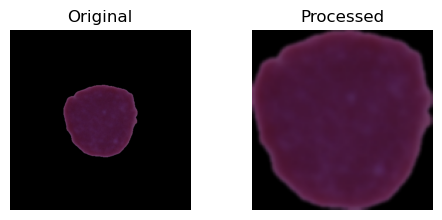

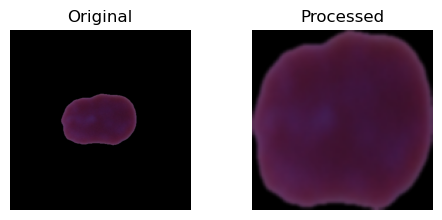

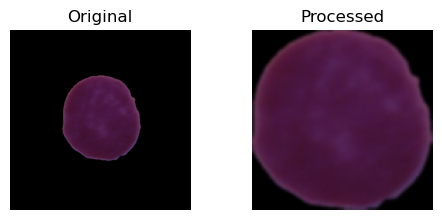

In [14]:
# display original and processed of 3 random images

for i in range(3):
    og_img = random.choice(train_paths)
    # find processed image with that name
    proc_img = None
    for proc_path in proc_paths:
        proc_name = proc_path.split("/")[-1]
        og_name = og_img.split("/")[-1]
        if proc_name == 'proc_' + og_name:
            proc_img = proc_path
            break 

    fig, axes = plt.subplots(1, 2, figsize=(5, 4))
    plt.tight_layout()
    axes[0].imshow(cv2.imread(og_img))
    axes[0].axis("off")
    axes[0].set_title('Original')
    axes[1].imshow(cv2.imread(proc_img))
    axes[1].axis("off")
    axes[1].set_title('Processed')

# Data Augmentation
Check for data imbalance and apply data augmentation to images in the smaller class.

In [15]:
# assign class for normal(hem) and leukemic(all) cells
image_classes = []
for file in proc_paths:
    image_class = 1 if 'all' in file else 0
    image_classes.append(image_class)

len(image_classes)

10661

In [16]:
all_imgs = []
hem_imgs = []

for img in proc_paths:
    if 'all' in img:
        all_imgs.append(img)
    else:
        hem_imgs.append(img)

hem_needed = (len(proc_paths)//2) - len(hem_imgs)
all_remove = len(all_imgs) - (len(proc_paths)//2)

print(f"Number of HEM cells: {len(hem_imgs)}")
print(f"Number of ALL cells: {len(all_imgs)}")
print(f"Number of HEM cells needed: {hem_needed}")
print(f"Number of ALL cells to be removed: {all_remove}")

Number of HEM cells: 3389
Number of ALL cells: 7272
Number of HEM cells needed: 1941
Number of ALL cells to be removed: 1942


In [17]:
# array of random ALL cells to be removed
all_be_removed = random.sample(all_imgs, all_remove)
len(all_be_removed)

1942

In [18]:
# array of random hem images to be augmented
aug_hem = random.sample(hem_imgs, hem_needed)
len(aug_hem)

1941

Data augmentation includes rotation and flipping of images

In [19]:
# function to rotate images
def rot_imgs(hem_img, angle):
    processed_dir = 'C-NMC_Leukemia/processed_data'
    image = cv2.imread(hem_img)
    
    # get dimensions of images
    rows, cols = image.shape[:2]
    # define matrix to be used for rotation with center and angle of rotation
    rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    # apply the matrix to rotate images using affine transformation
    rotated_image = cv2.warpAffine(image, rot_M, (cols, rows))

    rot_path = os.path.join(processed_dir, 'rot_' + hem_img.split("/")[-1])
    cv2.imwrite(rot_path, rotated_image)
    return rot_path

# function to flip images
def flip_imgs(hem_img, orientation):
    processed_dir = 'C-NMC_Leukemia/processed_data'
    image = cv2.imread(hem_img)
    
    # flip images in specified orientation
    flipped_image = cv2.flip(image, orientation)

    flip_path = os.path.join(processed_dir, 'flip_' + hem_img.split("/")[-1])
    cv2.imwrite(flip_path, flipped_image)
    return flip_path

Function to combine rotation and flipping functions on random images

In [20]:
def random_aug(hem):
    counter = random.randint(1, 10)
    if counter > 5:
        # rotate on random angles between 90 and 270
        hem = rot_imgs(hem, random.randint(90, 270))
    else:
        # random orientation of vertical or horizontal flipping
        hem = flip_imgs(hem, random.randint(0,1))
    return hem

In [21]:
# call random_aug function on aug_hem images
hem_added = []
for hem_img in aug_hem:
    augmented_hem = random_aug(hem_img)
    hem_added.append(augmented_hem)

len(hem_added)

1941

In [22]:
# add augmented images to processed paths
proc_paths.extend(hem_added)

In [23]:
# remove ALL cell images from processed paths
for i in all_be_removed:
    proc_paths.remove(i)

In [24]:
len(proc_paths)

10660

Equal number of classes with 0 adjustments to be made

In [25]:
all_imgs = []
hem_imgs = []

for img in proc_paths:
    if 'all' in img:
        all_imgs.append(img)
    else:
        hem_imgs.append(img)

hem_needed = (len(proc_paths)//2) - len(hem_imgs)
all_remove = len(all_imgs) - (len(proc_paths)//2)

print(f"Number of HEM cells: {len(hem_imgs)}")
print(f"Number of ALL cells: {len(all_imgs)}")
print(f"Number of HEM cells needed: {hem_needed}")
print(f"Number of ALL cells to be removed: {all_remove}")

Number of HEM cells: 5330
Number of ALL cells: 5330
Number of HEM cells needed: 0
Number of ALL cells to be removed: 0


### Splitting dataset into train, test and validation

#### Import libraries to split dataset

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# assign class for normal(hem) and leukemic(all) cells
image_classes = []
for file in proc_paths:
    image_class = 1 if 'all' in file else 0
    image_classes.append(image_class)

len(image_classes)

10660

In [28]:
# proc_paths = paths of every image
# convert to pixels array
image_pixels = []
for path in proc_paths:
    each_pix_arr = cv2.imread(path)
    image_pixels.append(each_pix_arr)

In [29]:
# images' pixels array as a numpy array
X = np.array(image_pixels)

# image classes, 0 or 1
y = np.array(image_classes)

In [30]:
# test set with 10% of dataset
test_size = 0.1

(X_train, X_test, 
 y_train, y_test) = train_test_split(X,
                                     y,
                                     test_size = test_size,
                                     stratify = y,
                                     shuffle = True,
                                     random_state = SEED)

In [31]:
# normalise pixels from [0, 255] to [0, 1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [32]:
# validation set with 10% of dataset
val_size = X_test.shape[0]

(X_train, X_val,
y_train, y_val) = train_test_split(X_train,
                                  y_train,
                                  test_size = val_size,
                                  stratify = y_train,
                                  random_state = SEED,
                                  shuffle = True)

In [33]:
# shapes of train, test and validation set
print('x_train:', X_train.shape)
print('y_train:', y_train.shape)

print('x_test:', X_test.shape)
print('y_test:', y_test.shape)

print('x_val:', X_val.shape)
print('y_val:', y_val.shape)

x_train: (8528, 128, 128, 3)
y_train: (8528,)
x_test: (1066, 128, 128, 3)
y_test: (1066,)
x_val: (1066, 128, 128, 3)
y_val: (1066,)


# Develop Models

### Import libraries
Libraries required for deep learning tasks

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


### Baseline model

Define baseline model architecture

In [35]:
# define layers
model = models.Sequential([
    layers.Flatten(input_shape = (128, 128, 3)),
    layers.Dense(1, activation = "sigmoid")
])

# model compilation
model.compile(optimizer = "adam", 
              loss = "binary_crossentropy", 
              metrics = ["accuracy"])

# Train the model
history = model.fit(X_train,
                    y_train,
                    batch_size = 32, 
                    epochs = 20,
                    validation_data = (X_val, y_val),
                    verbose = 1)

Epoch 1/20
267/267 [==============================] - 1s 4ms/step - loss: 0.8031 - accuracy: 0.5590 - val_loss: 0.6793 - val_accuracy: 0.5657
Epoch 2/20
267/267 [==============================] - 1s 3ms/step - loss: 0.7282 - accuracy: 0.5919 - val_loss: 0.6657 - val_accuracy: 0.6492
Epoch 3/20
267/267 [==============================] - 1s 3ms/step - loss: 0.7279 - accuracy: 0.6006 - val_loss: 1.2156 - val_accuracy: 0.5103
Epoch 4/20
267/267 [==============================] - 1s 3ms/step - loss: 0.7437 - accuracy: 0.6108 - val_loss: 0.6446 - val_accuracy: 0.6351
Epoch 5/20
267/267 [==============================] - 1s 3ms/step - loss: 0.6373 - accuracy: 0.6510 - val_loss: 0.6957 - val_accuracy: 0.6398
Epoch 6/20
267/267 [==============================] - 1s 3ms/step - loss: 0.6313 - accuracy: 0.6623 - val_loss: 0.7288 - val_accuracy: 0.6135
Epoch 7/20
267/267 [==============================] - 1s 3ms/step - loss: 0.6332 - accuracy: 0.6648 - val_loss: 0.6402 - val_accuracy: 0.6463
Epoch 

Display metrics of success for baseline model

In [36]:
# model evaluation
y_pred_prob = model.predict(X_val)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)

# precision, recall, and F1-score
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)

print("Accuracy: {:.4f}".format(test_acc))
print("Loss: {:.4f}".format(test_loss))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-Score: {:.4f}".format(f1))


34/34 [==============================] - 0s 2ms/step
Accuracy: 0.6932
Loss: 0.5904
Precision: 0.6886
Recall: 0.7054
F1-Score: 0.6969


Compare training and testing loss and accuracy over 20 epochs.

Baseline model training and testing loss and accuracy graphs: 


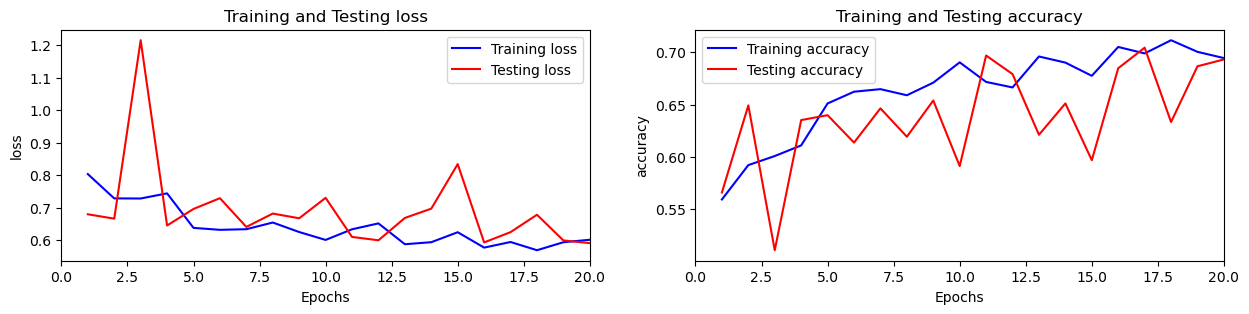

In [162]:
# Code adapted from François Chollet's Deep Learning with Python
print('Baseline model training and testing loss and accuracy graphs: ')
monitors = ['loss', 'accuracy']
fig, axs = plt.subplots(1, 2, sharex = 'all', figsize = (15, 3))

for ax, monitor in zip(axs.flat, monitors):
    history_dict = history.history
    loss, val_loss = history_dict[monitor], history_dict['val_' + monitor]
    epochs = range(1, len(loss) + 1)

    ax.plot(epochs, loss, 'b', label = 'Training ' + monitor)
    ax.plot(epochs, val_loss, 'r', label = 'Testing ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Testing ' + monitor)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()

plt.show()

Baseline model Confusion matrix: 


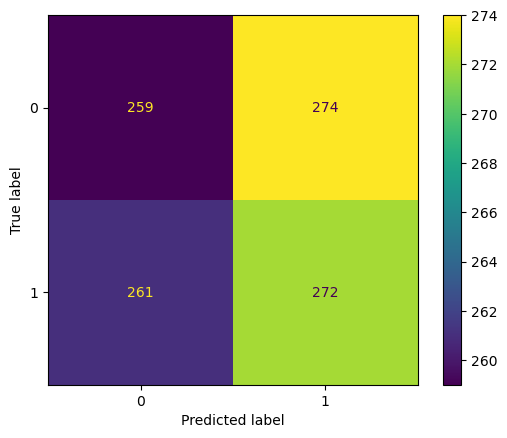

In [163]:
# plot confusion matrix
print('Baseline model Confusion matrix: ')
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, 
                                               (y_pred_binary > 0.5).astype('int32')))
disp.plot()
plt.show()

## CNN-1

## Declaring functions

Function to define CNN1 architecture

In [39]:
def build_CNN1(hidden_layers,
               no_of_filters,
               kernel_size,
               pool_size,
               activation,
               input_shape,
               hidden_neurons,
               loss,
               optimizer,
               metrics,
               name):
    
    model = Sequential()

    # feature extraction
    for layer in range(hidden_layers):
        no_of_filters = no_of_filters * 2
        # add convolutional layers in each hidden layer
        model.add(Conv2D(no_of_filters,
                         kernel_size, 
                         activation = activation, 
                         input_shape = 'default' if layer > 1 else (input_shape)))
        # add pooling layers for in each hidden layer
        model.add(MaxPooling2D(pool_size = pool_size))

    # classification
    model.add(Flatten())
    model.add(Dense(hidden_neurons,
                    activation = 'relu'))
    model.add(Dense(1, 
                    activation = 'sigmoid'))

    if name is not None:
        model._name = name

    model.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    
    return model


Function to train CNN1

In [48]:
def train_CNN(model,
              X,
              y,
              epochs,
              batch_size,
              val_data,
              callbacks = []):
    
    X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
    
    history = model.fit(X_train,
                        y_train,
                        epochs = epochs,
                        batch_size = batch_size,
                        validation_data = (X_val, y_val),
                        callbacks = callbacks)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val), 
            'history': history }

Function to plot accuracy and loss graphs for CNN1

In [41]:
def plot_history(history, monitors = ['loss', 'accuracy']):
    fig, axs = plt.subplots(1, 2, sharex = 'all', figsize = (15, 3))
    
    for ax, monitor in zip(axs.flat, monitors):
        loss, val_loss = history.history[monitor], history.history['val_' + monitor]
        epochs = range(1, len(loss) + 1)
        
        ax.plot(epochs, loss, 'b', label = 'Training ' + monitor)
        ax.plot(epochs, val_loss, 'r', label = 'Validation ' + monitor)
        ax.set_xlim([0, len(loss)])
        ax.title.set_text('Training and validation ' + monitor)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(monitor)
        ax.legend()
    
    _ = plt.show()

## Developing a model that does better than a baseline

In [49]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = lr)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

In [50]:
iter1_model = build_CNN1(hidden_layers = 3,
                        no_of_filters = 8,
                        kernel_size = (5,5),
                        pool_size = (2,2),
                        activation = 'relu',
                        input_shape = (128,128,3),
                        hidden_neurons = 64,
                        loss = LOSS_FUNC,
                        optimizer = OPTIMIZER,
                        metrics = METRICS,
                        name = "iter1_model")

iter1_model.summary()

Model: "iter1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 58, 58, 32)        12832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       

In [51]:
train_iter1_model = train_CNN(iter1_model,
                              X_train,
                              y_train,
                              epochs = 20,
                              batch_size = 64,
                              val_data = (X_val, y_val),
                              callbacks = None)

Epoch 1/20
134/134 [==============================] - 60s 440ms/step - loss: 0.6853 - accuracy: 0.5460 - precision: 0.5419 - recall: 0.5943 - auc: 0.5728 - val_loss: 0.6456 - val_accuracy: 0.6248 - val_precision: 0.6252 - val_recall: 0.6229 - val_auc: 0.6825
Epoch 2/20
134/134 [==============================] - 60s 446ms/step - loss: 0.6362 - accuracy: 0.6404 - precision: 0.6405 - recall: 0.6400 - auc: 0.6936 - val_loss: 0.6264 - val_accuracy: 0.6351 - val_precision: 0.6300 - val_recall: 0.6548 - val_auc: 0.7037
Epoch 3/20
134/134 [==============================] - 61s 458ms/step - loss: 0.5948 - accuracy: 0.6835 - precision: 0.6805 - recall: 0.6918 - auc: 0.7461 - val_loss: 0.5731 - val_accuracy: 0.6886 - val_precision: 0.7354 - val_recall: 0.5891 - val_auc: 0.7824
Epoch 4/20
134/134 [==============================] - 62s 459ms/step - loss: 0.5335 - accuracy: 0.7290 - precision: 0.7215 - recall: 0.7460 - auc: 0.8075 - val_loss: 0.5250 - val_accuracy: 0.7533 - val_precision: 0.7668 - v

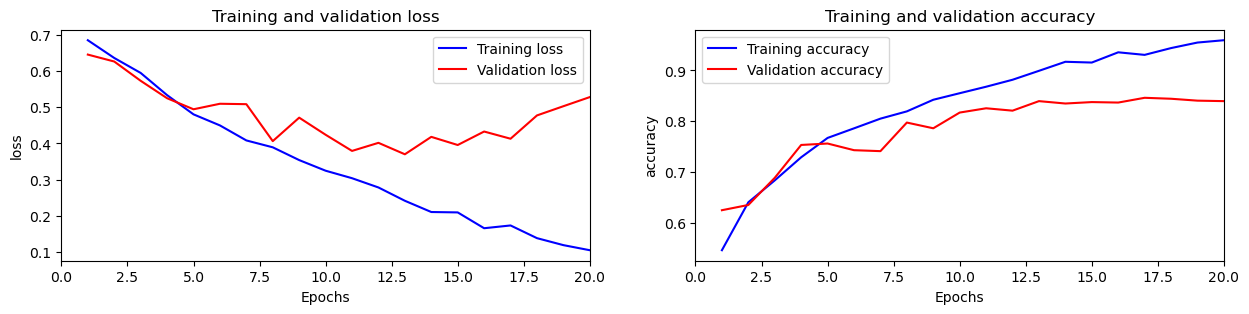

In [52]:
plot_history(train_iter1_model['history'], monitors = ['loss', 'accuracy'])

In [55]:
precision = train_iter1_model['val_score'][2]
recall = train_iter1_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('Accuracy: {:.4f}'.format(train_iter1_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_iter1_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_iter1_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_iter1_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

Accuracy: 0.8396
Loss: 0.5281
Precision: 0.7987
Recall: 0.9081
F1-score: 0.8499


## Initial regularisation to address overfitting

- increasing kernel size
- increasing no. of hidden units in fully connected dense layer

In [56]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = 0.001)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall')]

In [57]:
iter2_model = build_CNN1(hidden_layers = 3,
                        no_of_filters = 8,
                        kernel_size = (3,3),
                        pool_size = (2,2),
                        activation = 'relu',
                        input_shape = (128,128,3),
                        hidden_neurons = 32,
                        loss = LOSS_FUNC,
                        optimizer = OPTIMIZER,
                        metrics = METRICS,
                        name = "iter2_model")

iter2_model.summary()

Model: "iter2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)       

In [58]:
train_iter2_model = train_CNN(iter2_model,
                              X_train,
                              y_train,
                              epochs = 20,
                              batch_size = 64,
                              val_data = (X_val, y_val),
                              callbacks = None)

Epoch 1/20
134/134 [==============================] - 40s 292ms/step - loss: 0.6648 - accuracy: 0.6075 - precision: 0.6005 - recall: 0.6426 - val_loss: 0.6289 - val_accuracy: 0.6492 - val_precision: 0.6378 - val_recall: 0.6904
Epoch 2/20
134/134 [==============================] - 38s 285ms/step - loss: 0.5856 - accuracy: 0.6927 - precision: 0.6938 - recall: 0.6897 - val_loss: 0.5522 - val_accuracy: 0.7242 - val_precision: 0.7078 - val_recall: 0.7636
Epoch 3/20
134/134 [==============================] - 38s 284ms/step - loss: 0.5263 - accuracy: 0.7403 - precision: 0.7385 - recall: 0.7439 - val_loss: 0.6124 - val_accuracy: 0.6398 - val_precision: 0.8066 - val_recall: 0.3677
Epoch 4/20
134/134 [==============================] - 38s 282ms/step - loss: 0.4820 - accuracy: 0.7682 - precision: 0.7607 - recall: 0.7826 - val_loss: 0.4760 - val_accuracy: 0.7805 - val_precision: 0.7496 - val_recall: 0.8424
Epoch 5/20
134/134 [==============================] - 38s 285ms/step - loss: 0.4315 - accura

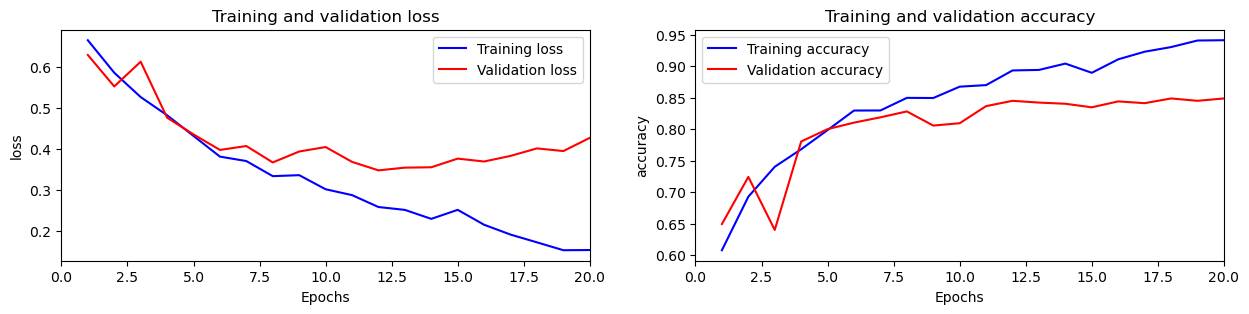

In [59]:
plot_history(train_iter2_model['history'], monitors = ['loss', 'accuracy'])

In [60]:
precision = train_iter2_model['val_score'][2]
recall = train_iter2_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('iter2_model')
print('Accuracy: {:.4f}'.format(train_iter2_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_iter2_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_iter2_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_iter2_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

iter2_model
Accuracy: 0.8490
Loss: 0.4268
Precision: 0.8382
Recall: 0.8649
F1-score: 0.8513


## Regularising model

Function for regularised model

In [61]:
from keras.layers import Dropout
from keras import regularizers

In [62]:
def build_reg_CNN(hidden_layers = 3,
                  no_of_filters = 8,
                  kernel_size = (3,3),
                  pool_size = (2,2),
                  activation = 'relu',
                  input_shape = (128,128,3),
                  hidden_neurons = 32,
                  loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'],
                  name = None,
                  dropout = None,
                  weight_regs = None):
    
    model = Sequential()

    # feature extraction
    for layer in range(hidden_layers):
        no_of_filters = no_of_filters * 2
        model.add(Conv2D(no_of_filters,
                         kernel_size, 
                         activation = activation, 
                         input_shape = 'default' if layer > 1 else (input_shape)))
        model.add(MaxPooling2D(pool_size = pool_size))

    # classification
    model.add(Flatten())
    model.add(Dense(hidden_neurons,
                    activation = 'relu',
                    kernel_regularizer = weight_regs))
    if dropout is not None:
        model.add(Dropout(dropout))
    model.add(Dense(1, 
                    activation = 'sigmoid'))

    if name is not None:
        model._name = name

    model.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    
    return model


### Add dropouts

In [63]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = lr)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall')]

DROPOUT = 0.1

dpout_model = build_reg_CNN(hidden_layers = 3,
                          no_of_filters = 8,
                          kernel_size = (3,3),
                          pool_size = (2,2),
                          activation = 'relu',
                          input_shape = (128,128,3),
                          hidden_neurons = 32,
                          loss = LOSS_FUNC,
                          optimizer = OPTIMIZER,
                          metrics = METRICS,
                          name = "dpout_model",
                          dropout = DROPOUT,
                          weight_regs = None)

In [64]:
train_dpout_model = train_CNN(dpout_model,
                            X_train, 
                            y_train,
                            epochs = 20,
                            batch_size = 64,
                            val_data = (X_val, y_val),
                            callbacks = None)

Epoch 1/20
134/134 [==============================] - 40s 287ms/step - loss: 0.6648 - accuracy: 0.6074 - precision: 0.6029 - recall: 0.6295 - val_loss: 0.6312 - val_accuracy: 0.6276 - val_precision: 0.6339 - val_recall: 0.6041
Epoch 2/20
134/134 [==============================] - 38s 282ms/step - loss: 0.6043 - accuracy: 0.6773 - precision: 0.6717 - recall: 0.6935 - val_loss: 0.5854 - val_accuracy: 0.6998 - val_precision: 0.6631 - val_recall: 0.8124
Epoch 3/20
134/134 [==============================] - 38s 282ms/step - loss: 0.5480 - accuracy: 0.7230 - precision: 0.7160 - recall: 0.7392 - val_loss: 0.5043 - val_accuracy: 0.7580 - val_precision: 0.7383 - val_recall: 0.7992
Epoch 4/20
134/134 [==============================] - 38s 283ms/step - loss: 0.4846 - accuracy: 0.7745 - precision: 0.7633 - recall: 0.7957 - val_loss: 0.4675 - val_accuracy: 0.7842 - val_precision: 0.7908 - val_recall: 0.7730
Epoch 5/20
134/134 [==============================] - 38s 283ms/step - loss: 0.4327 - accura

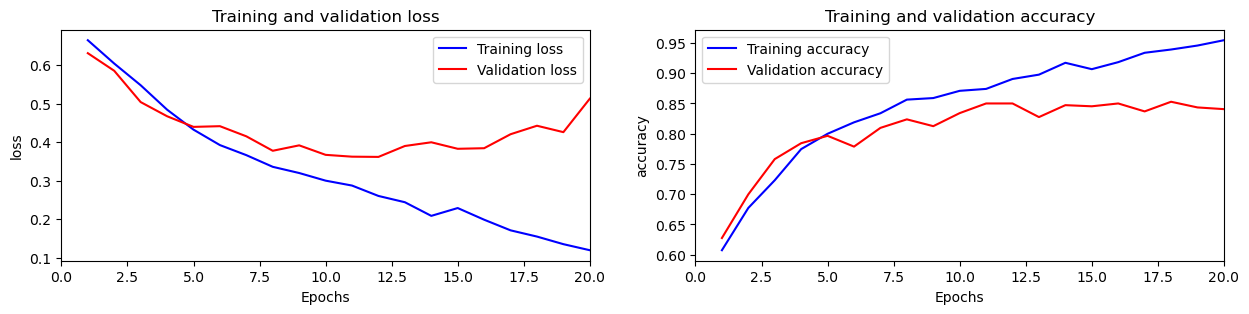

In [65]:
plot_history(train_dpout_model['history'], monitors = ['loss', 'accuracy'])

In [66]:
precision = train_dpout_model['val_score'][2]
recall = train_dpout_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('dpout_model')
print('Accuracy: {:.4f}'.format(train_dpout_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_dpout_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_dpout_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_dpout_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

dpout_model
Accuracy: 0.8405
Loss: 0.5131
Precision: 0.7840
Recall: 0.9400
F1-score: 0.8549


### L1 Regularisation

In [67]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = lr)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall')]
DROPOUT = 0.1

WEIGHT_REGS = regularizers.l1(0.001)

regL1_model = build_reg_CNN(hidden_layers = 3,
                          no_of_filters = 8,
                          kernel_size = (3,3),
                          pool_size = (2,2),
                          activation = 'relu',
                          input_shape = (128,128,3),
                          hidden_neurons = 32,
                          loss = LOSS_FUNC,
                          optimizer = OPTIMIZER,
                          metrics = METRICS,
                          name = "regL1_model",
                          dropout = DROPOUT,
                          weight_regs = WEIGHT_REGS)

In [68]:
train_regL1_model = train_CNN(regL1_model,
                            X_train, 
                            y_train,
                            epochs = 20,
                            batch_size = 64,
                            val_data = (X_val, y_val),
                            callbacks = None)

Epoch 1/20
134/134 [==============================] - 39s 285ms/step - loss: 1.0782 - accuracy: 0.5183 - precision: 0.5239 - recall: 0.4015 - val_loss: 0.7462 - val_accuracy: 0.6079 - val_precision: 0.5990 - val_recall: 0.6529
Epoch 2/20
134/134 [==============================] - 39s 290ms/step - loss: 0.7348 - accuracy: 0.5989 - precision: 0.5992 - recall: 0.5969 - val_loss: 0.7182 - val_accuracy: 0.6351 - val_precision: 0.6143 - val_recall: 0.7261
Epoch 3/20
134/134 [==============================] - 39s 294ms/step - loss: 0.7235 - accuracy: 0.6224 - precision: 0.6244 - recall: 0.6144 - val_loss: 0.7444 - val_accuracy: 0.5610 - val_precision: 0.6901 - val_recall: 0.2214
Epoch 4/20
134/134 [==============================] - 38s 283ms/step - loss: 0.7308 - accuracy: 0.6071 - precision: 0.6239 - recall: 0.5389 - val_loss: 0.7051 - val_accuracy: 0.6445 - val_precision: 0.5967 - val_recall: 0.8912
Epoch 5/20
134/134 [==============================] - 38s 284ms/step - loss: 0.6985 - accura

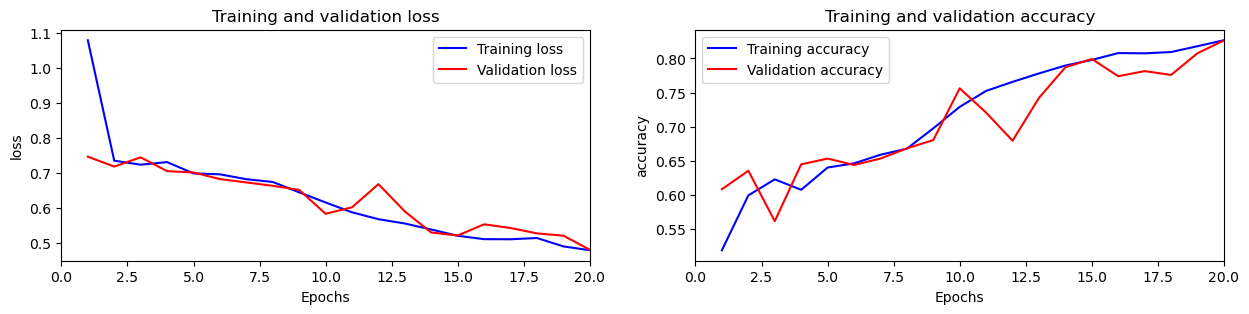

In [69]:
plot_history(train_regL1_model['history'], monitors = ['loss', 'accuracy'])

In [70]:
precision = train_regL1_model['val_score'][2]
recall = train_regL1_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('regL1_model')
print('Accuracy: {:.4f}'.format(train_regL1_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_regL1_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_regL1_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_regL1_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

regL1_model
Accuracy: 0.8265
Loss: 0.4810
Precision: 0.7881
Recall: 0.8931
F1-score: 0.8373


### L2 Regularisation

In [71]:
lr = 0.001
OPTIMIZER = Adam(learning_rate = lr)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall')]
DROPOUT = 0.1

WEIGHT_REGS = regularizers.l2(0.001)

regL2_model = build_reg_CNN(hidden_layers = 3,
                          no_of_filters = 8,
                          kernel_size = (3,3),
                          pool_size = (2,2),
                          activation = 'relu',
                          input_shape = (128,128,3),
                          hidden_neurons = 32,
                          loss = LOSS_FUNC,
                          optimizer = OPTIMIZER,
                          metrics = METRICS,
                          name = "regL2_model",
                          dropout = DROPOUT,
                          weight_regs = WEIGHT_REGS)

In [72]:
train_regL2_model = train_CNN(regL2_model,
                            X_train, 
                            y_train,
                            epochs = 20,
                            batch_size = 64,
                            val_data = (X_val, y_val),
                            callbacks = None)

Epoch 1/20
134/134 [==============================] - 39s 282ms/step - loss: 0.6721 - accuracy: 0.6184 - precision: 0.6134 - recall: 0.6405 - val_loss: 0.6334 - val_accuracy: 0.6604 - val_precision: 0.6482 - val_recall: 0.7017
Epoch 2/20
134/134 [==============================] - 38s 281ms/step - loss: 0.6112 - accuracy: 0.6874 - precision: 0.6800 - recall: 0.7078 - val_loss: 0.5969 - val_accuracy: 0.7054 - val_precision: 0.6763 - val_recall: 0.7880
Epoch 3/20
134/134 [==============================] - 39s 290ms/step - loss: 0.5634 - accuracy: 0.7292 - precision: 0.7242 - recall: 0.7404 - val_loss: 0.5845 - val_accuracy: 0.7017 - val_precision: 0.6409 - val_recall: 0.9174
Epoch 4/20
134/134 [==============================] - 40s 300ms/step - loss: 0.5125 - accuracy: 0.7738 - precision: 0.7675 - recall: 0.7856 - val_loss: 0.5822 - val_accuracy: 0.7120 - val_precision: 0.6392 - val_recall: 0.9737
Epoch 5/20
134/134 [==============================] - 38s 285ms/step - loss: 0.4713 - accura

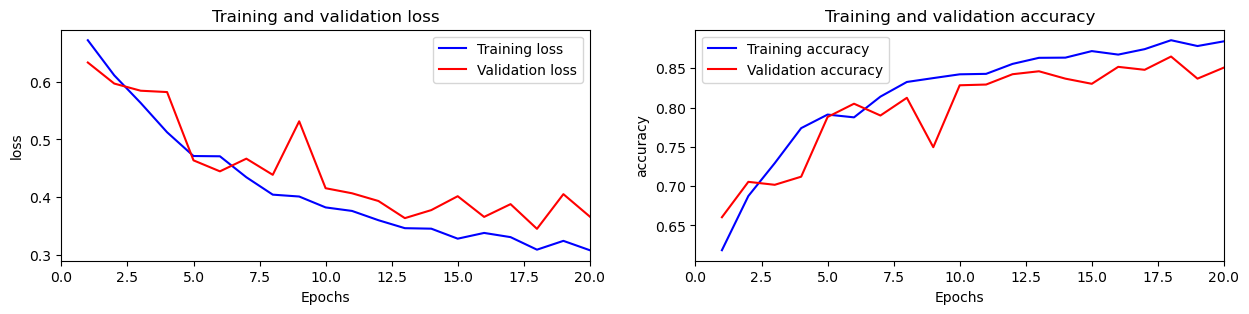

In [73]:
plot_history(train_regL2_model['history'], monitors = ['loss', 'accuracy'])

In [74]:
precision = train_regL2_model['val_score'][2]
recall = train_regL2_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('regL2_model')
print('Accuracy: {:.4f}'.format(train_regL2_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_regL2_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_regL2_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_regL2_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

regL2_model
Accuracy: 0.8508
Loss: 0.3663
Precision: 0.8066
Recall: 0.9231
F1-score: 0.8609


## Hyperparameters tuning

In [75]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [139]:
model = KerasClassifier(build_fn = build_reg_CNN, verbose = 0)
param_dist = {
    'pool_size': [(2,2), (4,4)],
    'dropout': [0.1, 0.3],
}

random_search = RandomizedSearchCV(estimator = model, 
                                   param_distributions = param_dist, 
                                   n_iter = 5, 
                                   scoring = 'accuracy', 
                                   cv = 3, 
                                   verbose = 1,
                                   error_score='raise')

random_search.fit(X_train, y_train)

/var/folders/f0/t9dz214d4_3d_q_bqc2tsfj40000gn/T/ipykernel_35238/150422605.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = build_reg_CNN, verbose = 0)
/Users/rajasuvedhavivekanandan/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits
89/89 [==============================] - 2s 18ms/step


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7faede411f00>,
                   n_iter=5,
                   param_distributions={'dropout': [0.1, 0.3],
                                        'pool_size': [(2, 2), (4, 4)]},
                   scoring='accuracy', verbose=1)

In [140]:
print("The best parameters:\n", random_search.best_params_)

The best parameters:
 {'pool_size': (4, 4), 'dropout': 0.1}


## Finalised CNN-1 with optimised hyperparameters

In [141]:
# optimised hyperparameters
POOL_SIZE = (4,4)
DROPOUT = 0.1

# other parameters
WEIGHT_REGS = regularizers.l2(0.001)
OPTIMIZER = Adam(learning_rate = 0.001)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall')]

In [142]:
cnn1_model = build_reg_CNN(hidden_layers = 3,
                          no_of_filters = 8,
                          kernel_size = (3,3),
                          pool_size = POOL_SIZE,
                          activation = 'relu',
                          input_shape = (128,128,3),
                          hidden_neurons = 32,
                          loss = LOSS_FUNC,
                          optimizer = OPTIMIZER,
                          metrics = METRICS,
                          name = "cnn1_model",
                          dropout = DROPOUT,
                          weight_regs = WEIGHT_REGS)

In [143]:
train_cnn1_model = train_CNN(cnn1_model,
                            X_train, 
                            y_train,
                            epochs = 20,
                            batch_size = 64,
                            val_data = (X_val, y_val),
                            callbacks = None)

Epoch 1/20
134/134 [==============================] - 24s 168ms/step - loss: 0.7057 - accuracy: 0.5510 - precision: 0.5403 - recall: 0.6846 - val_loss: 0.6694 - val_accuracy: 0.5966 - val_precision: 0.6359 - val_recall: 0.4522
Epoch 2/20
134/134 [==============================] - 24s 176ms/step - loss: 0.6598 - accuracy: 0.6194 - precision: 0.6241 - recall: 0.6001 - val_loss: 0.6800 - val_accuracy: 0.6060 - val_precision: 0.5655 - val_recall: 0.9156
Epoch 3/20
134/134 [==============================] - 19s 143ms/step - loss: 0.6468 - accuracy: 0.6439 - precision: 0.6464 - recall: 0.6353 - val_loss: 0.6402 - val_accuracy: 0.6398 - val_precision: 0.6265 - val_recall: 0.6923
Epoch 4/20
134/134 [==============================] - 20s 146ms/step - loss: 0.6245 - accuracy: 0.6663 - precision: 0.6682 - recall: 0.6606 - val_loss: 0.6154 - val_accuracy: 0.6707 - val_precision: 0.6585 - val_recall: 0.7092
Epoch 5/20
134/134 [==============================] - 19s 145ms/step - loss: 0.5742 - accura

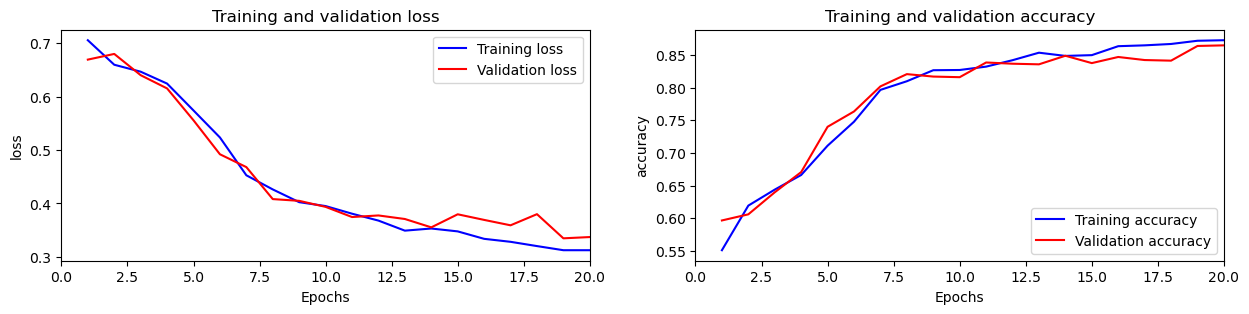

In [144]:
plot_history(train_cnn1_model['history'], monitors = ['loss', 'accuracy'])

In [145]:
precision = train_cnn1_model['val_score'][2]
recall = train_cnn1_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('cnn1_model')
print('Accuracy: {:.4f}'.format(train_cnn1_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_cnn1_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_cnn1_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_cnn1_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

cnn1_model
Accuracy: 0.8649
Loss: 0.3371
Precision: 0.8467
Recall: 0.8912
F1-score: 0.8684


## CNN-2, second model

In [146]:
from tensorflow.keras.layers import SeparableConv2D

In [147]:
def build_CNN2(hidden_layers,
              no_of_filters,
              kernel_size,
              pool_size,
              activation,
              input_shape,
              hidden_neurons,
              loss,
              optimizer,
              metrics,
              name,
              dropout,
              weight_regs):
    
    model = Sequential()

    # feature extraction 
    for layer in range(hidden_layers):
        no_of_filters = no_of_filters * 2
        # SeparableConv2D instead of Conv2D
        model.add(SeparableConv2D(no_of_filters,
                                 kernel_size, 
                                 activation = activation, 
                                 input_shape = 'default' if layer > 1 else (input_shape)))
        model.add(MaxPooling2D(pool_size = pool_size))

    # classification
    model.add(Flatten())
    model.add(Dense(hidden_neurons,
                    activation = 'relu',
                    kernel_regularizer = weight_regs))
    if ~np.isnan(dropout):
            model.add(Dropout(dropout))
    model.add(Dense(1, 
                    activation = 'sigmoid'))

    if name is not None:
        model._name = name

    model.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    
    return model

In [148]:
# optimised hyperparameters
POOL_SIZE = (4,4)
DROPOUT = 0.1

# other parameters
WEIGHT_REGS = regularizers.l2(0.001)
OPTIMIZER = Adam(learning_rate = 0.001)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall')]

In [149]:
cnn2_model = build_CNN2(hidden_layers = 3,
                      no_of_filters = 8,
                      kernel_size = (3,3),
                      pool_size = (2,2),
                      activation = 'relu',
                      input_shape = (128,128,3),
                      hidden_neurons = 32,
                      loss = LOSS_FUNC,
                      optimizer = OPTIMIZER,
                      metrics = METRICS,
                      name = "cnn2_model",
                      dropout = DROPOUT,
                      weight_regs = WEIGHT_REGS)
cnn2_model.summary()

Model: "cnn2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_12 (Separa  (None, 126, 126, 16)     91        
 bleConv2D)                                                      
                                                                 
 max_pooling2d_177 (MaxPooli  (None, 63, 63, 16)       0         
 ng2D)                                                           
                                                                 
 separable_conv2d_13 (Separa  (None, 61, 61, 32)       688       
 bleConv2D)                                                      
                                                                 
 max_pooling2d_178 (MaxPooli  (None, 30, 30, 32)       0         
 ng2D)                                                           
                                                                 
 separable_conv2d_14 (Separa  (None, 28, 28, 64)       2

In [150]:
train_cnn2_model = train_CNN(cnn2_model,
                            X_train, 
                            y_train,
                            epochs = 20,
                            batch_size = 64,
                            val_data = (X_val, y_val),
                            callbacks = None)

Epoch 1/20
134/134 [==============================] - 38s 272ms/step - loss: 0.6966 - accuracy: 0.4945 - precision: 0.4969 - recall: 0.8874 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9944
Epoch 2/20
134/134 [==============================] - 37s 273ms/step - loss: 0.6922 - accuracy: 0.5192 - precision: 0.5159 - recall: 0.6234 - val_loss: 0.6938 - val_accuracy: 0.5356 - val_precision: 0.7375 - val_recall: 0.1107
Epoch 3/20
134/134 [==============================] - 37s 274ms/step - loss: 0.6781 - accuracy: 0.6011 - precision: 0.5958 - recall: 0.6288 - val_loss: 0.6743 - val_accuracy: 0.6107 - val_precision: 0.6143 - val_recall: 0.5947
Epoch 4/20
134/134 [==============================] - 35s 265ms/step - loss: 0.6690 - accuracy: 0.6290 - precision: 0.6194 - recall: 0.6691 - val_loss: 0.6704 - val_accuracy: 0.6285 - val_precision: 0.5969 - val_recall: 0.7917
Epoch 5/20
134/134 [==============================] - 35s 259ms/step - loss: 0.6646 - accura

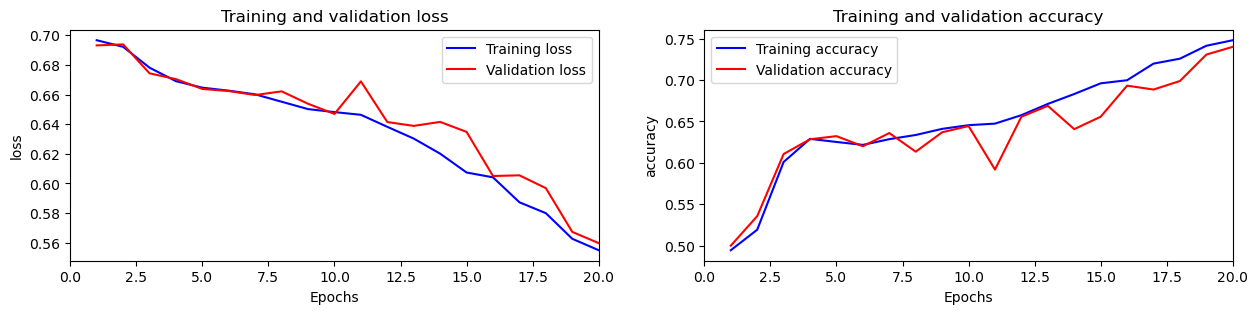

In [151]:
plot_history(train_cnn2_model['history'], monitors = ['loss', 'accuracy'])

In [152]:
precision = train_cnn2_model['val_score'][2]
recall = train_cnn2_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('cnn2_model')
print('Accuracy: {:.4f}'.format(train_cnn2_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_cnn2_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_cnn2_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_cnn2_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

cnn2_model
Accuracy: 0.7402
Loss: 0.5597
Precision: 0.7550
Recall: 0.7111
F1-score: 0.7324


## CNN-1 with VGG16 base model

In [114]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [115]:
def build_pretrain(activation,
                  input_shape,
                  hidden_neurons,
                  loss,
                  optimizer,
                  metrics,
                  name,
                  dropout,
                  weight_regs):
    
    model = Sequential()
    
    # Feature extraction using VGG16 as the base model
    conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)
    conv_base.trainable = False
    model.add(conv_base)
    
    # classification
    model.add(Flatten())
    model.add(Dense(hidden_neurons,
                    activation = 'relu',
                    kernel_regularizer = weight_regs))
    if dropout is not None:
        model.add(Dropout(dropout))
    model.add(Dense(1, 
                    activation = 'sigmoid'))

    if name is not None:
        model._name = name

    model.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    
    return model

In [116]:
# optimised hyperparameters
DROPOUT = 0.1
WEIGHT_REGS = regularizers.l2(0.001)

OPTIMIZER = Adam(learning_rate = 0.001)
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall')]

vgg16_model = build_pretrain(activation = 'relu',
                          input_shape = (128,128,3),
                          hidden_neurons = 32,
                          loss = LOSS_FUNC,
                          optimizer = OPTIMIZER,
                          metrics = METRICS,
                          name = "vgg16_model",
                          dropout = DROPOUT,
                          weight_regs = WEIGHT_REGS)

vgg16_model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_44 (Flatten)        (None, 8192)              0         
                                                                 
 dense_87 (Dense)            (None, 32)                262176    
                                                                 
 dropout_40 (Dropout)        (None, 32)                0         
                                                                 
 dense_88 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14,976,897
Trainable params: 262,209
Non-trainable params: 14,714,688
_________________________________________________________________


In [117]:
print('This is the number of trainable weights '
          'after freezing the conv base:', len(vgg16_model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [119]:
train_vgg16_model = train_CNN(vgg16_model,
                              X_train,
                              y_train,
                              epochs = 10,
                              batch_size = 64,
                              val_data = (X_val, y_val),
                              callbacks = None)

Epoch 1/10
134/134 [==============================] - 286s 2s/step - loss: 0.6574 - accuracy: 0.6303 - precision: 0.6258 - recall: 0.6482 - val_loss: 0.6194 - val_accuracy: 0.6942 - val_precision: 0.6468 - val_recall: 0.8555
Epoch 2/10
134/134 [==============================] - 392s 3s/step - loss: 0.6017 - accuracy: 0.6934 - precision: 0.6877 - recall: 0.7085 - val_loss: 0.5813 - val_accuracy: 0.7158 - val_precision: 0.6904 - val_recall: 0.7824
Epoch 3/10
134/134 [==============================] - 493s 4s/step - loss: 0.5859 - accuracy: 0.7047 - precision: 0.6933 - recall: 0.7343 - val_loss: 0.5764 - val_accuracy: 0.7148 - val_precision: 0.7573 - val_recall: 0.6323
Epoch 4/10
134/134 [==============================] - 477s 4s/step - loss: 0.5626 - accuracy: 0.7269 - precision: 0.7151 - recall: 0.7542 - val_loss: 0.5596 - val_accuracy: 0.7383 - val_precision: 0.7055 - val_recall: 0.8180
Epoch 5/10
134/134 [==============================] - 375s 3s/step - loss: 0.5504 - accuracy: 0.7338

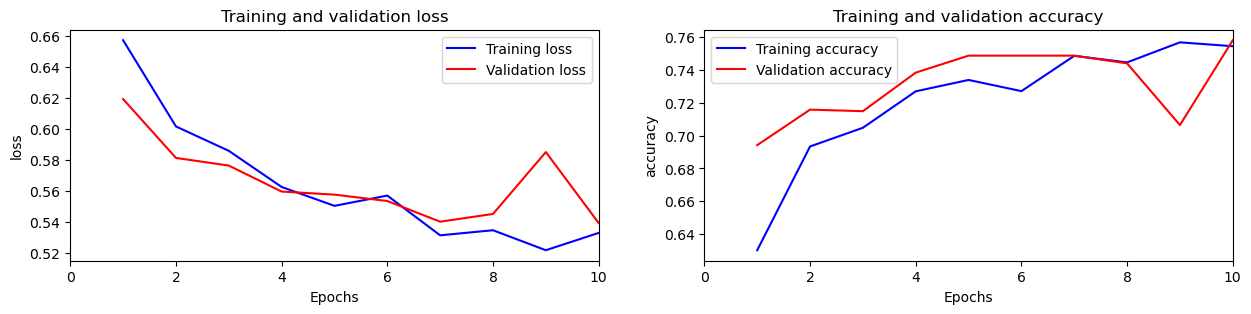

In [120]:
plot_history(train_vgg16_model['history'], monitors = ['loss', 'accuracy'])

In [121]:
precision = train_vgg16_model['val_score'][2]
recall = train_vgg16_model['val_score'][3]
f1_score = 2 * (precision * recall) / (precision + recall)

print('vgg16_model')
print('Accuracy: {:.4f}'.format(train_vgg16_model['val_score'][1]))
print('Loss: {:.4f}'.format(train_vgg16_model['val_score'][0]))
print('Precision: {:.4f}'.format(train_vgg16_model['val_score'][2]))
print('Recall: {:.4f}'.format(train_vgg16_model['val_score'][3]))
print('F1-score: {:.4f}'.format(f1_score))

vgg16_model
Accuracy: 0.7580
Loss: 0.5392
Precision: 0.7639
Recall: 0.7467
F1-score: 0.7552


## Test every model on unseen test data

### Training on all training data

In [122]:
def train_CNN_all(model, 
                  X, 
                  y, 
                  epochs, 
                  batch_size, 
                  callbacks=[]):
    
    history = model.fit(X, 
                        y, 
                        epochs = epochs, 
                        batch_size = batch_size, 
                        callbacks = callbacks)

    return {'model': model, 
            'history': history}

In [123]:
full_data = (np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

In [153]:
# CNN-1 model
train_cnn1_model = train_CNN_all(cnn1_model,
                                 full_data[0],
                                 full_data[1], 
                                 epochs = 20,
                                 batch_size = 64,
                                 callbacks = None)

Epoch 1/20
150/150 [==============================] - 23s 155ms/step - loss: 0.3078 - accuracy: 0.8768 - precision: 0.8590 - recall: 0.9016
Epoch 2/20
150/150 [==============================] - 22s 147ms/step - loss: 0.3140 - accuracy: 0.8715 - precision: 0.8515 - recall: 0.8999
Epoch 3/20
150/150 [==============================] - 22s 147ms/step - loss: 0.2995 - accuracy: 0.8797 - precision: 0.8591 - recall: 0.9085
Epoch 4/20
150/150 [==============================] - 21s 140ms/step - loss: 0.2875 - accuracy: 0.8866 - precision: 0.8696 - recall: 0.9095
Epoch 5/20
150/150 [==============================] - 21s 138ms/step - loss: 0.2809 - accuracy: 0.8886 - precision: 0.8709 - recall: 0.9124
Epoch 6/20
150/150 [==============================] - 21s 137ms/step - loss: 0.2786 - accuracy: 0.8914 - precision: 0.8738 - recall: 0.9149
Epoch 7/20
150/150 [==============================] - 21s 139ms/step - loss: 0.2642 - accuracy: 0.8991 - precision: 0.8836 - recall: 0.9193
Epoch 8/20
150/150 [

In [154]:
# CNN-2 model
train_cnn2_model = train_CNN_all(cnn2_model,
                                 full_data[0],
                                 full_data[1], 
                                 epochs = 20,
                                 batch_size = 64,
                                 callbacks = None)

Epoch 1/20
150/150 [==============================] - 36s 239ms/step - loss: 0.5419 - accuracy: 0.7579 - precision: 0.7689 - recall: 0.7373
Epoch 2/20
150/150 [==============================] - 36s 241ms/step - loss: 0.5420 - accuracy: 0.7565 - precision: 0.7687 - recall: 0.7338
Epoch 3/20
150/150 [==============================] - 36s 239ms/step - loss: 0.5288 - accuracy: 0.7642 - precision: 0.7784 - recall: 0.7388
Epoch 4/20
150/150 [==============================] - 36s 242ms/step - loss: 0.5128 - accuracy: 0.7785 - precision: 0.7852 - recall: 0.7667
Epoch 5/20
150/150 [==============================] - 36s 241ms/step - loss: 0.4948 - accuracy: 0.7885 - precision: 0.7967 - recall: 0.7747
Epoch 6/20
150/150 [==============================] - 36s 240ms/step - loss: 0.4878 - accuracy: 0.7941 - precision: 0.8059 - recall: 0.7749
Epoch 7/20
150/150 [==============================] - 37s 244ms/step - loss: 0.4825 - accuracy: 0.7957 - precision: 0.8090 - recall: 0.7742
Epoch 8/20
150/150 [

In [127]:
# VGG16 model
train_vgg16_model = train_CNN_all(vgg16_model,
                                  full_data[0],
                                  full_data[1], 
                                  epochs = 10,
                                  batch_size = 64,
                                  callbacks = None)

Epoch 1/10
150/150 [==============================] - 291s 2s/step - loss: 0.5153 - accuracy: 0.7616 - precision: 0.7437 - recall: 0.7984
Epoch 2/10
150/150 [==============================] - 334s 2s/step - loss: 0.5219 - accuracy: 0.7613 - precision: 0.7394 - recall: 0.8070
Epoch 3/10
150/150 [==============================] - 328s 2s/step - loss: 0.5124 - accuracy: 0.7637 - precision: 0.7439 - recall: 0.8043
Epoch 4/10
150/150 [==============================] - 326s 2s/step - loss: 0.5088 - accuracy: 0.7683 - precision: 0.7486 - recall: 0.8080
Epoch 5/10
150/150 [==============================] - 330s 2s/step - loss: 0.4967 - accuracy: 0.7764 - precision: 0.7521 - recall: 0.8247
Epoch 6/10
150/150 [==============================] - 381s 3s/step - loss: 0.5123 - accuracy: 0.7660 - precision: 0.7420 - recall: 0.8155
Epoch 7/10
150/150 [==============================] - 341s 2s/step - loss: 0.5009 - accuracy: 0.7754 - precision: 0.7526 - recall: 0.8205
Epoch 8/10
150/150 [==============

### Testing on unseen data

In [155]:
CNN1_preds = train_cnn1_model['model'].predict(X_test)

34/34 [==============================] - 1s 22ms/step


In [156]:
CNN2_preds = train_cnn2_model['model'].predict(X_test)

34/34 [==============================] - 2s 43ms/step


In [157]:
VGG16_preds = train_vgg16_model['model'].predict(X_test)

34/34 [==============================] - 33s 968ms/step


### Each model's performance

In [158]:
models = [('CNN1', CNN1_preds), ('CNN2', CNN2_preds), ('CNN-1 with VGG16 base model', VGG16_preds)]

#### Metrics for each model

In [159]:
for model_name, preds in models:
    print(f'Results for {model_name}:')
    
    accuracy = accuracy_score(y_test, (preds > 0.5).astype('int32'))
    precision = precision_score(y_test, (preds > 0.5).astype('int32'))
    recall = recall_score(y_test, (preds > 0.5).astype('int32'))
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1_score: {:.2f}\n'.format(f1))

Results for CNN1:
Accuracy: 0.87
Precision: 0.85
Recall: 0.91
F1_score: 0.88

Results for CNN2:
Accuracy: 0.79
Precision: 0.85
Recall: 0.72
F1_score: 0.78

Results for CNN-1 with VGG16 base model:
Accuracy: 0.76
Precision: 0.74
Recall: 0.80
F1_score: 0.77



#### Confusion matrix for each model

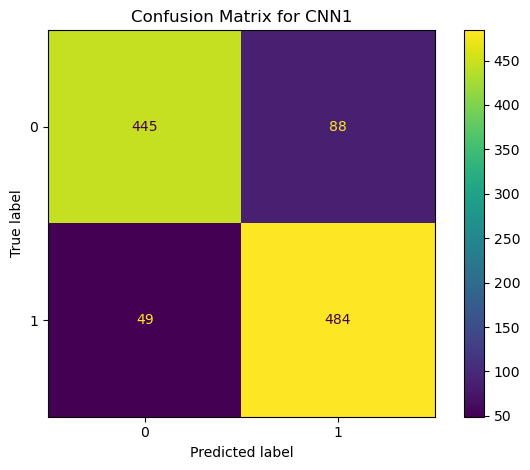

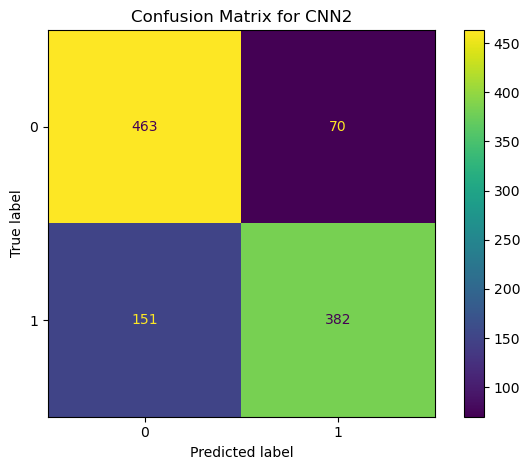

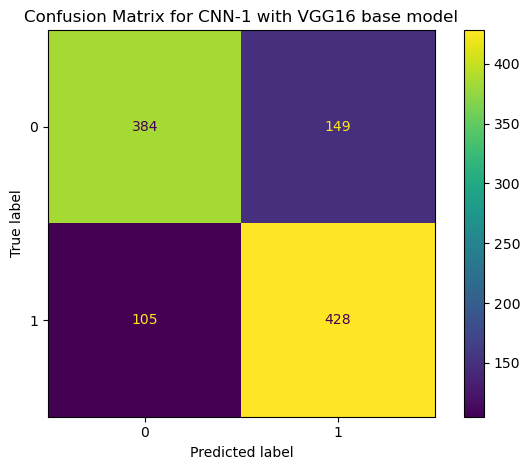

In [160]:
for model, preds in models:
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, (preds > 0.5).astype('int32')))
    disp.plot()
    plt.title(f'Confusion Matrix for {model}')
    plt.tight_layout()
    plt.show()